In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [2]:
crypto_currency = 'BTC'
against_currency = 'USD'

# Colect data
start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [3]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-10,68789.625000,63208.113281,66953.335938,64995.230469,4.873083e+10,64995.230469
2021-11-11,65579.015625,64180.488281,64978.890625,64949.960938,3.588063e+10,64949.960938
2021-11-12,65460.816406,62333.914062,64863.980469,64155.941406,3.608489e+10,64155.941406
2021-11-13,64915.675781,63303.734375,64158.121094,64469.527344,3.047423e+10,64469.527344
2021-11-14,65285.769531,64128.273438,64500.128906,64580.839844,2.738828e+10,64580.839844


## LSTM

In [4]:
# prepare data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))


prediction_days = 60 # look at this number of days so we can predict the futute
future_day = 30


# Prepare the train data
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    x_train.append(scaled_data[x-prediction_days:x, 0]) # x in not included
    y_train.append(scaled_data[x + future_day, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
# create neural network
# downgrade numpy to 1.19.5


model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2)) #Float between 0 and 1. Fraction of the input units to drop.
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2)) 
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
65/65 [==============================] - 3s 53ms/step - loss: 0.0114
Epoch 2/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0081
Epoch 3/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0061
Epoch 4/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0050
Epoch 5/25
65/65 [==============================] - 4s 56ms/step - loss: 0.0048
Epoch 6/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0057
Epoch 7/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0040
Epoch 8/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0044
Epoch 9/25
65/65 [==============================] - 4s 59ms/step - loss: 0.0043
Epoch 10/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0044
Epoch 11/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0036
Epoch 12/25
65/65 [==============================] - 4s 55ms/step - loss: 0.0041
Epoch 13/25
65/65 [==================

In [6]:
# Testing the model

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [7]:
model_inputs = total_dataset[len(total_dataset)-len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

In [8]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

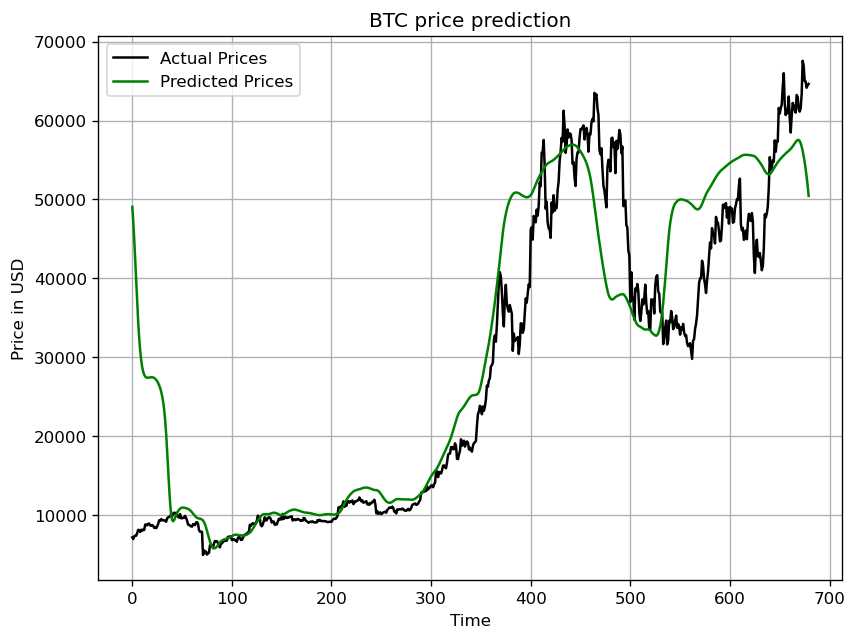

In [9]:
figure(figsize=(8, 6), dpi=120)

plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [10]:
# Predict next day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f'The actual price is: {round(actual_prices[len(actual_prices)-1], 2)} $')
print(f'According to this model, the price after {future_day} days would be: {prediction} $')


The actual price is: 64634.69 $
According to this model, the price after 30 days would be: [[49131.906]] $


## Linear Regression

In [11]:
# get the adjusted close price

lin_data = data[['Adj Close']]
lin_data.head()


,Adj Close
Date,
2016-01-01,434.334015
2016-01-02,433.437988
2016-01-03,430.010986
2016-01-04,433.091003
2016-01-05,431.959991


In [12]:
# this variable stores the days in the future we want to predict

forecast_out = future_day

In [13]:
# create another column shifted 'n' units up
lin_data['Prediction'] = lin_data[['Adj Close']].shift(-forecast_out)

C:\Users\VGEORG~1\AppData\Local\Temp/ipykernel_5824/2183354185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_data['Prediction'] = lin_data[['Adj Close']].shift(-forecast_out)


In [14]:
lin_data.tail()

,Adj Close,Prediction
Date,,
2021-11-10,64995.230469,NaN
2021-11-11,64949.960938,NaN
2021-11-12,64155.941406,NaN
2021-11-13,64469.527344,NaN
2021-11-14,64580.839844,NaN


In [15]:
### Create the independent dataset (X)

# create the dataframe to numpy array
X = np.array(lin_data.drop(['Prediction'],1))

# remove the last 'n' rows thats equals to 'frocast_out'
X = X[:-forecast_out]

X

C:\Users\VGEORG~1\AppData\Local\Temp/ipykernel_5824/3583924510.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(lin_data.drop(['Prediction'],1))


array([[  434.33401489],
       [  433.43798828],
       [  430.01098633],
       ...,
       [57401.09765625],
       [57321.5234375 ],
       [61593.94921875]])

In [16]:
## Create the dependent dataset

# create a dataframe as numpy array with all the values, incl. the NaNs
y = np.array(lin_data['Prediction'])

# get all the 'y' values except the last 'n' rows thats equals to 'frocast_out'
y = y[:-forecast_out]

y

array([  368.76699829,   373.05599976,   374.44799805, ...,
       64155.94140625, 64469.52734375, 64580.83984375])

In [17]:
# Split the data to 80% training and 20% testing 

lin_x_train, lin_x_test, lin_y_train, lin_y_test = train_test_split(X, y, test_size=0.2)

In [18]:
# Create and train Support Vectior Machine (Regressor)

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(lin_x_train, lin_y_train)

SVR(C=1000.0, gamma=0.1)

In [19]:
# Testing model: Scrore returns the coefficient of determination R^2 of the prediction.
# The best possible score is 1.0

svm_confidence = svr_rbf.score(lin_x_test, lin_y_test)
print(f'SVM score: {svm_confidence}')


SVM score: -0.07214463394505444


In [20]:
lr = LinearRegression()

In [21]:
lr.fit(lin_x_train, lin_y_train)

LinearRegression()

In [22]:
# Testing model: Scrore returns the coefficient of determination R^2 of the prediction.
# The best possible score is 1.0

lr_confidence = lr.score(lin_x_test, lin_y_test)
print(f'Linaer Reg score: {lr_confidence}')

Linaer Reg score: 0.9145607259951222


In [23]:
# set x_forecast equal to the last 30 rows Adj Close of the original dataset

x_forecast = np.array(lin_data.drop(['Prediction'], 1))[-forecast_out:]
x_forecast

C:\Users\VGEORG~1\AppData\Local\Temp/ipykernel_5824/1918092244.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_forecast = np.array(lin_data.drop(['Prediction'], 1))[-forecast_out:]


array([[60892.1796875 ],
       [61553.6171875 ],
       [62026.078125  ],
       [64261.9921875 ],
       [65992.8359375 ],
       [62210.171875  ],
       [60692.265625  ],
       [61393.6171875 ],
       [60930.8359375 ],
       [63039.82421875],
       [60363.79296875],
       [58482.38671875],
       [60622.13671875],
       [62227.96484375],
       [61888.83203125],
       [61318.95703125],
       [61004.40625   ],
       [63226.40234375],
       [62970.046875  ],
       [61452.23046875],
       [61125.67578125],
       [61527.48046875],
       [63326.98828125],
       [67566.828125  ],
       [66971.828125  ],
       [64995.23046875],
       [64949.9609375 ],
       [64155.94140625],
       [64469.52734375],
       [64580.83984375]])

In [24]:
# predict for the next 'n' days ahead with Linear regression

lr_prediction = lr.predict(x_forecast)
lr_prediction

array([63443.04781294, 64126.85539953, 64615.29515904, 66926.82874898,
       68716.21034203, 64805.6150349 , 63236.37257513, 63961.44413413,
       63483.01143311, 65663.32656001, 62896.7908394 , 60951.75466106,
       63163.87188061, 64824.00976913, 64473.4073463 , 63884.25894088,
       63559.06992365, 65856.21483346, 65591.18931798, 64022.03974051,
       63684.44084001, 64099.83472627, 65960.20262847, 70343.43558863,
       69728.31244545, 67684.86544859, 67638.06488329, 66817.19128697,
       67141.38282904, 67256.45996329])

In [25]:
# predict for the next 'n' days ahead with SVM

svm_prediction = svr_rbf.predict(x_forecast)
svm_prediction

array([7374.33238885, 7374.33238885, 7374.33238885, 7374.33238885,
       7374.33238885, 7374.33238885, 7375.13124447, 7374.33238885,
       7374.33238885, 7374.33238885, 7374.33238885, 7374.33238885,
       7374.33238885, 7374.33238885, 7374.33238885, 7374.33238885,
       7374.33238885, 7374.33238885, 7374.33238885, 7374.33238885,
       7374.33238885, 7374.33238885, 7374.33243747, 7374.33238885,
       7374.33238885, 7374.33238885, 7374.33238885, 7374.33238885,
       7374.33238885, 7374.33238885])

In [26]:
print(f'According to LSTM model, the price after {future_day} days would be: {prediction} $')


According to LSTM model, the price after 30 days would be: [[49131.906]] $


In [27]:
print(f'The actual price is: {round(actual_prices[len(actual_prices)-1], 2)} $')

The actual price is: 64634.69 $
